In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utility import get_spotify_data, get_spotify_client
import spotipy as sp
import plotly.express as px

- Get all artists 
- Remove duplicates
- Call Spotify api to get related artists
- Remove the ones that aren't in my artists
- Connect each related artists to the base artist
- Show a graph/web graph

In [2]:
streaming_history = get_spotify_data('StreamingHistory')
streaming_history[:3]

[{'endTime': '2020-12-22 22:45',
  'artistName': 'meganeko',
  'trackName': 'Stasis',
  'msPlayed': 226000},
 {'endTime': '2020-12-22 22:59',
  'artistName': 'meganeko',
  'trackName': 'Robot Language',
  'msPlayed': 190008},
 {'endTime': '2020-12-22 23:05',
  'artistName': 'meganeko',
  'trackName': 'Robot Language',
  'msPlayed': 8435}]

In [3]:
df = pd.DataFrame.from_records(streaming_history)
df.head()

,endTime,artistName,trackName,msPlayed
0,2020-12-22 22:45,meganeko,Stasis,226000
1,2020-12-22 22:59,meganeko,Robot Language,190008
2,2020-12-22 23:05,meganeko,Robot Language,8435
3,2020-12-22 23:06,meganeko,she speaks,57000
4,2020-12-22 23:10,meganeko,Super Gamer Girl 3D,289500


In [4]:
df.sort_values('endTime').head()

,endTime,artistName,trackName,msPlayed
67426,2019-12-16 00:21,Panic! At The Disco,Crazy = Genius,4940
67427,2020-03-07 18:13,Johann Sebastian Bach,"Bach, J.S.: Brandenburg Concerto No. 5 in D Ma...",31018
67428,2020-03-10 21:28,Austin Wintory,Temptations,236307
67429,2020-03-11 00:03,Ace Waters,Nihilist (feat. ThunderScott),88040
67430,2020-03-11 00:12,Ace Waters,Nihilist (feat. ThunderScott),3241


In [5]:
artist_df = df.groupby('artistName').sum('msPlayed')
artist_df['artist'] = artist_df.index
artist_df['hrsPlayed'] = artist_df['msPlayed'] / 60000 / 60
artist_df

,msPlayed,artist,hrsPlayed
artistName,,,
"""Weird Al"" Yankovic",57255270,"""Weird Al"" Yankovic",15.904242
10 Years,18156,10 Years,0.005043
100 gecs,0,100 gecs,0.000000
1000say,37,1000say,0.000010
11 Acorn Lane,11819316,11 Acorn Lane,3.283143
...,...,...,...
zabutom,1316335,zabutom,0.365649
zebrahead,12637,zebrahead,0.003510
zircon,3463824,zircon,0.962173


[Text(0.5, 0, 'Hours Played')]

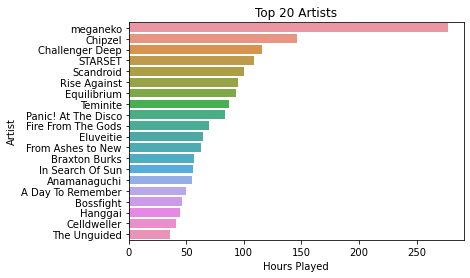

In [6]:
top_n_artists = 20
plotted_artist_df = artist_df.sort_values(by='hrsPlayed', ascending=False)[:top_n_artists]
ax = sns.barplot(data=plotted_artist_df, x='hrsPlayed', y='artist', orient='h')
ax.set(title=f'Top {top_n_artists} Artists')
ax.set(ylabel='Artist')
ax.set(xlabel='Hours Played')

In [7]:
%%capture
sp = get_spotify_client()

In [31]:
# n_artists: int = 10_000
limited_artists = artist_df.sort_values(by='hrsPlayed', ascending=False) # [:n_artists]
_artists = [sp.search(q=artist, limit=1, type='artist')['artists']['items'] for artist in limited_artists['artist']]
artists = [artist[0] for artist in _artists if len(artist) > 0]

In [48]:
artists_big_df_raw = pd.DataFrame.from_records(artists, index='id', exclude=['external_urls', 'followers', 'href', 'images', 'type']).rename({'name': 'artist'}, axis=1)
artists_big_df_raw['id'] = artists_big_df_raw.index
artists_big_df = artists_big_df_raw.merge(artist_df, on=['artist']).explode('genres').drop_duplicates()
artists_big_df.head()

,genres,artist,popularity,uri,id,msPlayed,hrsPlayed
0,chiptune,meganeko,46,spotify:artist:5tXUIbGjW1uqXoy8cPW8MB,5tXUIbGjW1uqXoy8cPW8MB,997539090,277.094192
0,speedrun,meganeko,46,spotify:artist:5tXUIbGjW1uqXoy8cPW8MB,5tXUIbGjW1uqXoy8cPW8MB,997539090,277.094192
1,chiptune,Chipzel,43,spotify:artist:6mgvN6ZusGnE2uz5WWO3nC,6mgvN6ZusGnE2uz5WWO3nC,525259956,145.905543
1,speedrun,Chipzel,43,spotify:artist:6mgvN6ZusGnE2uz5WWO3nC,6mgvN6ZusGnE2uz5WWO3nC,525259956,145.905543
2,instrumental math rock,Challenger Deep,32,spotify:artist:4UeFbnKOjmVX7tQoxEhw2G,4UeFbnKOjmVX7tQoxEhw2G,416204856,115.612460


In [33]:
artists_big_df[artists_big_df['genres'].str.contains('rap', na=False)][['name','genres']].drop_duplicates()

,name,genres
id,,
4HrkLxQHZ5mgCtIVpiH5QX,From Ashes to New,rap rock
4BKyei61gtyDFxlKhcvBJJ,Celldweller,rap rock
2Zxy5LwBatI5kw4uponwHQ,Riot Ten,electronic trap
6XyY86QOPPrYVGvF9ch6wz,Linkin Park,rap metal
1tG7s7S4sq2eFFW0QZyLbm,Sheff G,nyc rap
...,...,...
0Y5tJX1MQlPlqiwlOH1tJY,Travis Scott,rap
0ycHhPwPvoaO4VGzmMnXGq,Zomboy,electronic trap
7qAcXJgt1PWnxwUgxMdyuk,Sick Puppies,rap rock


In [34]:
artists_big_df[['name','genres']].drop_duplicates('name').to_csv('./yeet.csv')

In [35]:
artists_big_df['genres'].unique()

array(['chiptune', 'speedrun', 'instrumental math rock', 'future rock',
       'cyberpunk', 'darksynth', 'synthwave', 'chicago hardcore',
       'chicago punk', 'hardcore punk', 'pop punk', 'punk', 'folk metal',
       'german metal', 'german pagan metal', 'melodic death metal',
       'power metal', 'viking metal', 'edm', 'baroque pop', 'emo',
       'modern rock', 'conscious hip hop', 'bow pop', 'celtic metal',
       'hurdy-gurdy', 'swiss metal', 'alternative metal', 'gymcore',
       'rap rock', 'otacore', 'pokemon', 'scorecore', 'uk metalcore',
       'bitpop', 'indie game soundtrack', 'japanese vgm', 'nintendocore',
       'metalcore', 'screamo', 'electro house', 'gaming edm',
       'mongolian folk', 'throat singing', 'industrial metal',
       'industrial rock', 'nu metal', 'melodic groove metal',
       'swedish metalcore', 'metal', 'chillstep', 'electronic djent',
       'finnish metal', 'melodic metalcore', 'welsh metal', 'comic metal',
       'indian metal', 'post-grunge', 

In [36]:
genres_df = artists_big_df.groupby('genres').count().sort_values(by='id', ascending=False)
genres_df['genre'] = genres_df.index
genres_df.head()

,name,popularity,uri,id,genre
genres,,,,,
pop,142,142,142,142,pop
dance pop,113,113,113,113,dance pop
electro house,104,104,104,104,electro house
edm,100,100,100,100,edm
alternative metal,95,95,95,95,alternative metal


In [37]:
plotted_genres = genres_df[genres_df['id'] >= 40]
plotted_genres.shape

(25, 5)

[Text(0, 0.5, 'Genre')]

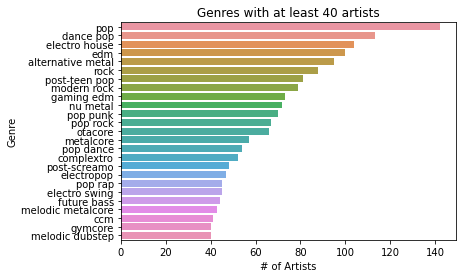

In [38]:
ax = sns.barplot(data=plotted_genres, x='id', y='genre', orient='h')
ax.set(title='Genres with at least 40 artists')
ax.set(xlabel='# of Artists')
ax.set(ylabel='Genre')

<AxesSubplot:xlabel='id', ylabel='genre'>

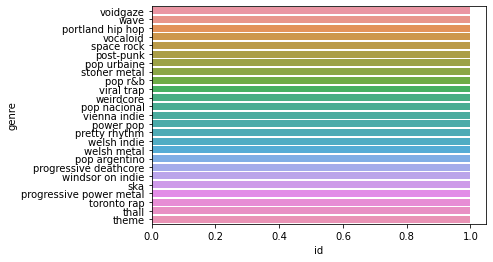

In [39]:
sns.barplot(data=genres_df[genres_df['id'] == 1][20:45], x='id', y='genre', orient='h')

In [40]:
artists_big_df_raw.head()

,genres,name,popularity,uri,id
id,,,,,
5tXUIbGjW1uqXoy8cPW8MB,"[chiptune, speedrun]",meganeko,46,spotify:artist:5tXUIbGjW1uqXoy8cPW8MB,5tXUIbGjW1uqXoy8cPW8MB
6mgvN6ZusGnE2uz5WWO3nC,"[chiptune, speedrun]",Chipzel,43,spotify:artist:6mgvN6ZusGnE2uz5WWO3nC,6mgvN6ZusGnE2uz5WWO3nC
4UeFbnKOjmVX7tQoxEhw2G,[instrumental math rock],Challenger Deep,32,spotify:artist:4UeFbnKOjmVX7tQoxEhw2G,4UeFbnKOjmVX7tQoxEhw2G
0kD8IT1CzF7js2XKM9lLLa,[future rock],STARSET,70,spotify:artist:0kD8IT1CzF7js2XKM9lLLa,0kD8IT1CzF7js2XKM9lLLa
27qG899eLldfpYtPr3S3NJ,"[cyberpunk, darksynth, synthwave]",Scandroid,54,spotify:artist:27qG899eLldfpYtPr3S3NJ,27qG899eLldfpYtPr3S3NJ


In [41]:
artist_df.head()

,msPlayed,artist,hrsPlayed
artistName,,,
"""Weird Al"" Yankovic",57255270,"""Weird Al"" Yankovic",15.904242
10 Years,18156,10 Years,0.005043
100 gecs,0,100 gecs,0.000000
1000say,37,1000say,0.000010
11 Acorn Lane,11819316,11 Acorn Lane,3.283143


In [42]:
artist_df.shape, artists_big_df_raw.shape

((1778, 3), (1770, 5))

In [ ]:
artist_df